Total energy now contains local density-density interactions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd


torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "smooth" # "smooth" or "rough"

N_grid = 512 # number of grid points
if data_regime == "smooth":
    M_cutoff = 50 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 10000
lr = 1e-3 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training


kernel_regime = "double_Gaussian" # "single_Gaussian" or "double_Gaussian" 
if kernel_regime == "single_Gaussian":
    amp_Gaussian = 1.0 # amplitude of Gaussian kernel for interaction energy
    sigma_Gaussian = 3.0 # width of Gaussian kernel for interaction energy
elif kernel_regime == "double_Gaussian":
    amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
    sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
    amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
    sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")

Setup the functional and sample density profiles 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


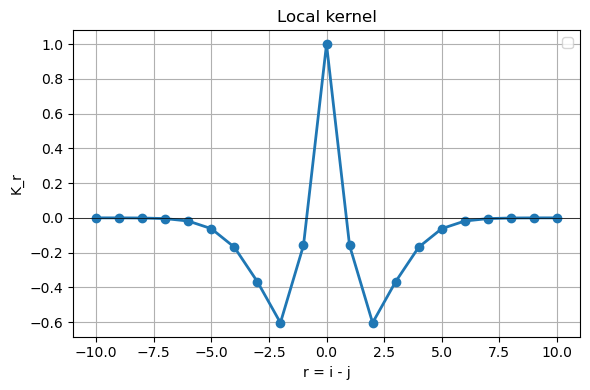

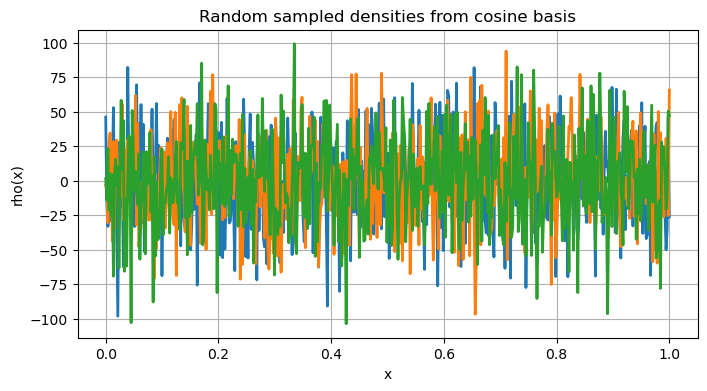

In [23]:
def sample_density(*, rho_b=0.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density has zero mean over the grid points
    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix
    d_rho_a = a @ DerDM  # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean()

    return rho, d_rho_a, a

def sample_density_batch(B: int, rho_b=0.0):
    """
    Sample a batch of B density profiles
    Spatial average density rho_avg is set to zero
    Returns rho: (B, N_grid)
    """

    a = torch.normal(torch.zeros(B, std_harm.numel(),dtype=dtype, device=device), std_harm.expand(B, -1))
    rho = a @ DesignMatrix  # (B, N_grid)
    d_rho_a = a @ DerDM  # (B, N_grid) # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean(dim=1, keepdim=True)
    return rho, d_rho_a, a

# density–density interaction kernels K(r)
# r: tensor (can be negative)
def K_gaussian(r, sigma=1.0):       # strictly local-ish
    r = r.to(dtype=dtype)
    return torch.exp(-(r**2) / (sigma**2))

def K_exp(r, xi=2.0):              # short–to–intermediate range
    r = r.to(dtype=dtype)
    return torch.exp(-torch.abs(r) / xi)

def K_yukawa(r, lam=10.0):         # long-range but screened
    r = torch.abs(r).to(dtype=dtype)
    r = r.clamp(min=1.0)         # avoid r=0 singularity
    return torch.exp(-r / lam) / r

def K_power(r, alpha=1.0):         # unscreened long range (Coulomb-like for alpha=1)
    r = torch.abs(r).to(dtype=dtype)
    r = r.clamp(min=1.0)
    return 1.0 / (r**alpha)

def E_int_conv(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor: 
    """
    Interaction energy using convolution
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function (sigma, xi, lam, alpha, etc.)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K_fun = K_gaussian
    elif kernel == "exp":
        K_fun = K_exp
    elif kernel == "yukawa":
        K_fun = K_yukawa
    elif kernel == "power":
        K_fun = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    # ensure batch dim
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    # r = -(N-1)..(N-1), kernel length = 2N-1
    r_vals = torch.arange(-(N-1), N, device=device, dtype=dtype)  # (2N-1,)
    k_full = K_fun(r_vals, **kwargs)                              # (2N-1,)

    weight = k_full.view(1, 1, -1)                # (1,1,2N-1)
    u = F.conv1d(rho.unsqueeze(1), weight, padding=N-1).squeeze(1) # (B, N)
    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


if kernel_regime == "single_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return amp_Gaussian * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian)
elif kernel_regime == "double_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return (amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1) +
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2))


R = 10 
r_grid = torch.arange(-R, R+1)

plt.figure(figsize=(6,4))
if kernel_regime == "single_Gaussian":
    plt.plot(r_grid, amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian), 'o-', linewidth=2)
elif kernel_regime == "double_Gaussian":
    plt.plot(r_grid, amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2), 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Local kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


rho_batch, _, _ = sample_density_batch(3)  # (B, N_grid)
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()



Feature processing (generation and normalization)

In [3]:
# we save features as (B, N_grid, N_feat), where N_feat is the number of features per grid point
# generate train/test split

def compute_normalization_stats(features):
    """
    Compute mean and std for features with shape (N_data, N_grid, N_feat)
    Averages over both data and spatial dimensions
    
    Args:
        features: torch.Tensor of shape (N_data, N_grid, N_feat)
    
    Returns:
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)
    """

    mean_feat = features.mean(dim=(0, 1), keepdim=True)  # Shape: (1, 1, N_feat)
    std_feat = features.std(dim=(0, 1), keepdim=True) # Shape: (1, 1, N_feat)
    
    return mean_feat, std_feat

def normalize_features(features, mean_feat, std_feat):
    """
    Normalize features using provided or computed statistics
    
    Args:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)

    Returns:
        normalized_features: torch.Tensor of same shape as input
        mean: mean used for normalization
        std: std used for normalization
    """
    normalized_features = (features - mean_feat) / std_feat

    return normalized_features

def generate_loc_features_rs(rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density rho
    rs, real space   
    Args:
        rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form rho^k, k=1,...,N_feat
    """
    features = [rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

def generate_loc_features_ms(d_rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density derivative d_rho
    ms, momentum space
    Args:
        d_rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form d_rho^k, k=1,...,N_feat
    """
    features = [d_rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

rho_train, d_rho_train, a_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val)    # (N_val, N_grid)

N_feat = 1 

features_train_rs = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_rs  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_rs   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train_ms = generate_loc_features_ms(d_rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_ms  = generate_loc_features_ms(d_rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_ms   = generate_loc_features_ms(d_rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train = torch.cat([features_train_rs, features_train_ms], dim=-1)
features_test  = torch.cat([features_test_rs, features_test_ms], dim=-1)
features_val   = torch.cat([features_val_rs, features_val_ms], dim=-1)

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

Correlation function analysis

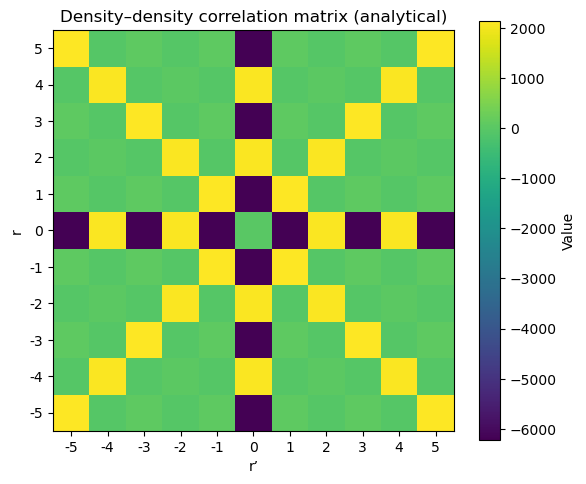

In [4]:
# Analytical routines

def C_mm(m_vals: torch.Tensor, r_vals: torch.Tensor, N: int) -> torch.Tensor:
    """
    Compute C_mm(r) for a list of m-values and r-values.
    Handles the singular mode m = N-1 cleanly.
    
    Returns: (M, R) tensor
    """
    dtype = m_vals.dtype
    device = m_vals.device

    m = m_vals.view(-1, 1)              # (M,1)
    r = torch.abs(r_vals).view(1, -1)   # (1,R)

    pi = torch.tensor(math.pi, dtype=dtype, device=device)
    theta = pi * m / (N - 1)            # (M,1)

    # First term: (1/2) cos(theta*r)
    term1 = 0.5 * torch.cos(theta * r)

    # denominator sin(theta)
    den = torch.sin(theta)              # (M,1)

    # numerator sin(theta * (N-r))
    num = torch.sin(theta * (N - r))    # (M,R)

    # (-1)^m 
    sign = (m_vals.to(torch.long) % 2)*(-2) + 1  
    # maps even -> 1, odd -> -1
    sign = sign.view(-1,1).to(dtype)

    # general closed-form (will have 0/0 for m=N-1)
    term2 = 0.5 * sign * (num / den) / (N - r)

    # m = N-1  (exact expression = (-1)^r)
    mask_sing = (m_vals == (N-1))
    if mask_sing.any():
        idx = torch.nonzero(mask_sing, as_tuple=False).view(-1)
        C_sing = torch.cos(pi * r)          # (-1)^r
        term2[idx, :] = C_sing - term1[idx, :]   # enforce full C = term1+term2 ⇒ C=cos(pi*r)

    C = term1 + term2
    return C

def C_m1m2_sym(m_vals: torch.Tensor, r_vals: torch.Tensor, N: int) -> torch.Tensor:
    """
    Compute the symmetrized correlator C_{m1,m2}(r) for all m1,m2 and r.

    Formula:
        C_{m1, m2}(r) =
            [cos(pi (m1 - m2)/2) / (2 (N - |r|))] *
            [ sin(pi (m1 - m2)(N - |r|)/(2 (N-1))) *
              cos(pi (m1 + m2)|r|/(2 (N-1))) ] /
            sin(pi (m1 - m2)/(2 (N-1)))
        +
            [cos(pi (m1 + m2)/2) / (2 (N - |r|))] *
            [ sin(pi (m1 + m2)(N - |r|)/(2 (N-1))) *
              cos(pi (m1 - m2)|r|/(2 (N-1))) ] /
            sin(pi (m1 + m2)/(2 (N-1)))

    Might require more care for singular cases where the denominators vanish.

    Returns:
        C: (M, M, R) tensor where C[m1_idx, m2_idx, r_idx] = C_{m1,m2}(r)
    """
    dtype = m_vals.dtype
    device = m_vals.device
    M = m_vals.numel()

    # Shapes: (M,1,1) and (1,M,1)
    m1 = m_vals.view(-1, 1, 1)    # (M,1,1)
    m2 = m_vals.view(1, -1, 1)    # (1,M,1)

    # |r| as (1,1,R)
    r_abs = torch.abs(r_vals).view(1, 1, -1).to(device)  # (1,1,R)

    pi = torch.tensor(math.pi, dtype=dtype, device=device)

    # Convenient combos
    d = m1 - m2  # (M,M,1)
    s = m1 + m2  # (M,M,1)

    # N - |r| as (1,1,R)
    L = N - r_abs

    # Common denominators: alpha_d = pi d / [2 (N-1)], alpha_s = pi s / [2 (N-1)]
    alpha_d = pi * d / (2 * (N - 1))  # (M,M,1)
    alpha_s = pi * s / (2 * (N - 1))  # (M,M,1)

    # Denominators
    den_d = torch.sin(alpha_d)       # (M,M,1)
    den_s = torch.sin(alpha_s)       # (M,M,1)

    # Small epsilon to avoid division by exact 0
    eps = 1e-12
    den_d_safe = den_d.clone()
    den_s_safe = den_s.clone()
    den_d_safe[den_d_safe.abs() < eps] = eps
    den_s_safe[den_s_safe.abs() < eps] = eps

    # Numerators for the two terms
    num_d = torch.sin(pi * d * L / (2 * (N - 1))) * \
            torch.cos(pi * s * r_abs / (2 * (N - 1)))  # (M,M,R)

    num_s = torch.sin(pi * s * L / (2 * (N - 1))) * \
            torch.cos(pi * d * r_abs / (2 * (N - 1)))  # (M,M,R)

    # Prefactors cos(pi (m1±m2)/2) / [2 (N - |r|)]
    pref_d = torch.cos(pi * d / 2.0) / (2.0 * L)   # (M,M,R)
    pref_s = torch.cos(pi * s / 2.0) / (2.0 * L)   # (M,M,R)

    termA = pref_d * (num_d / den_d_safe)          # (M,M,R)
    termB = pref_s * (num_s / den_s_safe)          # (M,M,R)

    C = termA + termB  # (M,M,R), general off-diagonal expression

    # --- Diagonal correction: m1 == m2 ---
    # For diagonal we use the exact C_mm(r), including the m = N-1 singular mode
    C_diag = C_mm(m_vals, r_vals, N)   # (M,R)

    idx = torch.arange(M, device=device)
    C[idx, idx, :] = C_diag            # overwrite diagonal slices

    return C


def C_m1m2_sym_def(m_vals: torch.Tensor, r_vals: torch.Tensor, N: int) -> torch.Tensor:
    """
    Compute the symmetrized correlator C_{m1,m2}(r) from the *definition*:

        x_j = (j)/(N-1), j = 0,...,N-1
        phi_m(j) = cos(pi m x_j)

        tilde C_{m1,m2}(r) = 1/(N-|r|) sum_{i=0}^{N-|r|-1}
                             phi_{m1}(i) phi_{m2}(i+|r|)
        C_{m1,m2}(r) = 0.5[ tilde C_{m1,m2}(r) + tilde C_{m2,m1}(r) ]

    Args:
        m_vals: (M,) tensor of modes m >= 1
        r_vals: (R,) tensor of integer r (can be positive or negative)
        N:      number of grid points

    Returns:
        C: (M, M, R) tensor with C[m1_idx, m2_idx, r_idx] = C_{m1,m2}(r)
    """
    dtype = m_vals.dtype
    device = m_vals.device

    m_vals = m_vals.to(dtype=dtype, device=device)
    r_vals = r_vals.to(device=device)

    M = m_vals.numel()
    Rlen = r_vals.numel()

    # grid x_j = j/(N-1), j = 0,...,N-1 (this matches x_j = (j-1)/(N-1) with a shift)
    j = torch.arange(0, N, device=device, dtype=dtype)       # (N,)
    x = j / (N - 1)                                          # (N,)

    # phi[m, j] = cos(pi m x_j)
    pi = torch.tensor(math.pi, dtype=dtype, device=device)
    phi = torch.cos(pi * m_vals.view(M, 1) * x.view(1, N))   # (M, N)

    # Output tensor
    C = torch.empty((M, M, Rlen), dtype=dtype, device=device)

    for idx, r in enumerate(r_vals):
        k = abs(int(r.item()))
        L = N - k  # number of terms in sum

        # segments phi(:, i) and phi(:, i+k)
        A = phi[:, :L]          # (M, L)
        B = phi[:, k:k+L]       # (M, L)

        # tilde_C[m1, m2](r) = 1/L sum_i A[m1,i] * B[m2,i]
        # => (M,L) @ (M,L)^T with appropriate transpose:
        # we want A * B for (m1,m2) so:
        tilde_C = (A @ B.t()) / L    # (M, M)

        # symmetrize: C = 0.5(tilde_C + tilde_C^T)
        C_sym = 0.5 * (tilde_C + tilde_C.T)  # (M, M)

        C[:, :, idx] = C_sym

    return C

def second_moment_analytical(R: int, N: int) -> float:
    """
    Second moment of the density–density correlation function,
    computed analytically from the harmonic expansion.
    """

    gamma2 = std_harm**2      # (M,)
    r_vals = torch.arange(-R, R+1, device=device)   # (2R+1,)
    
    C = (gamma2.unsqueeze(1) * C_mm(m, r_vals, N_grid)).sum(dim=0) # (2R+1,)
    M1 = C.view(-1, 1) * C.view(1, -1)   # (2R+1, 2R+1)

    C_m1m2 = C_m1m2_sym_def(m, r_vals, N_grid) #C_m1m2_sym(m, r_vals, N_grid) # (M, M, 2R+1)
    w = gamma2.view(m.numel(), 1, 1, 1) * gamma2.view(1, m.numel(), 1, 1)   # (M, M, 1, 1)
    C_r  = C_m1m2.unsqueeze(-1)   # (M, M, 2R+1, 1)
    C_rp = C_m1m2.unsqueeze(-2)   # (M, M, 1, 2R+1)

    prod = w * C_r * C_rp
    M2 = 2.0 * prod.sum(dim=(0, 1))          # (2R+1, 2R+1)

    return M1 + M2

R = 5
C_avg_analytical = ((std_harm**2).unsqueeze(1) * C_mm(m, torch.arange(-R, R+1), N_grid)).sum(dim=0)
M_analytical = second_moment_analytical(R, N_grid)

# Visualize the correlation matrix 
M_analytical[R, R] = 0.0
M_analytical = M_analytical.detach().cpu().numpy()
plt.figure(figsize=(6,5))
plt.imshow(M_analytical, origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label="Value")
r_vals = torch.arange(-R, R+1)
r_vals = r_vals.cpu().numpy()
ticks = np.arange(len(r_vals))
plt.xticks(ticks, r_vals)
plt.yticks(ticks, r_vals)
plt.xlabel("r’")
plt.ylabel("r")
plt.title("Density–density correlation matrix (analytical)")
plt.tight_layout()
plt.show()


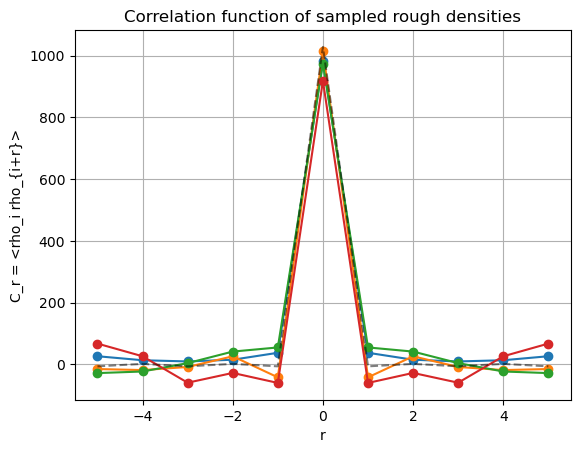

tensor([264939.5492,   2467.7017,   2066.6389,   1975.0144,   1922.0677,
          1882.5751], dtype=torch.float64)
tensor([ 1.0000, -0.1582, -0.6030, -0.3650, -0.1675, -0.0617],
       dtype=torch.float64)


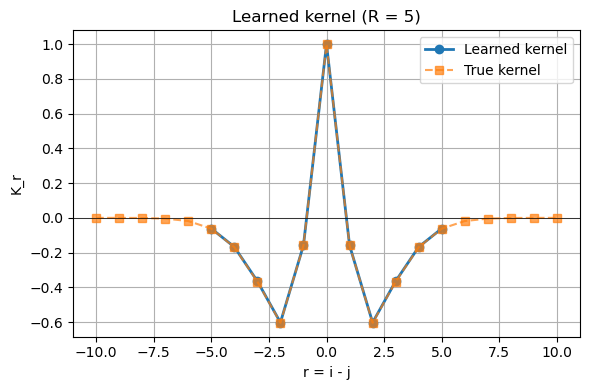

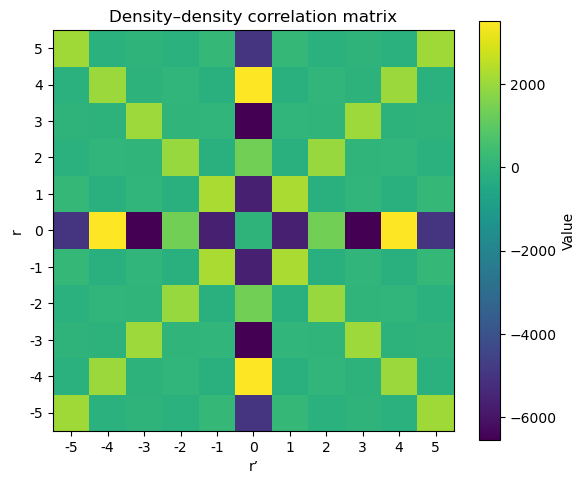

Max relative difference between numerical and analytical C(r): 0.0014952333578648182
Max relative difference between numerical and analytical correlation matrix: 0.059776837225928955


In [5]:
def dens_dens_corr_func(rho_batch: torch.Tensor, R: int) -> torch.Tensor:
    """
    Compute numerically the correlation function C(r) for each sample in the batch

    Args:
        rho_batch: tensor of shape (B, N)
        R: maximum displacement (integer)

    Returns:
        C: tensor of shape (B, 2R+1)
           C[b, k] = c_b(r) for r = -R + k, k = 0,...,2R
    """
    B, N = rho_batch.shape
    Cs = []

    for r in range(-R, R + 1):
        if r == 0:
            prod = rho_batch * rho_batch / N                       # (B, N)
        elif r > 0:
            # i = 0..N-1-r, i+r = r..N-1
            prod = rho_batch[:, :N - r] * rho_batch[:, r:] / (N - r)    # (B, N-r)
        else:  # r < 0
            k = -r
            # i = k..N-1, i+r = i-k = 0..N-1-k
            prod = rho_batch[:, k:] * rho_batch[:, :N - k] / (N - k)    # (B, N-k)

        C_r = prod.sum(dim=1)                               # (B,)
        Cs.append(C_r)
        
    return torch.stack(Cs, dim=1)

def dens_dens_corr_func_sym(rho_batch: torch.Tensor, R: int) -> torch.Tensor:
    B, N = rho_batch.shape
    Cs = []

    for r in range(0, R + 1):
        if r == 0:
            prod = 0.5 * rho_batch * rho_batch / N                      # (B, N)
        else:
            prod = 0.5 * (rho_batch[:, :N - r] * rho_batch[:, r:] + rho_batch[:, r:] * rho_batch[:, :N - r]) / (N - r)

        C_r = prod.sum(dim=1)                              # (B,)
        Cs.append(C_r)
        
    return torch.stack(Cs, dim=1)

def make_symmetric(K_vec: torch.Tensor) -> torch.Tensor:
    """
    K_vec: tensor of shape (R+1,) or (R+1, 1) with entries K(0..R)
    Returns: tensor of shape (2R+1,) with K(-R..R), assuming K(-r) = K(r).
    """
    # Make sure it's a 1D tensor
    if K_vec.ndim > 1:
        K_vec = K_vec.squeeze()

    R = K_vec.shape[0] - 1

    # K(1..R) reversed → negative side
    K_left  = torch.flip(K_vec[1:], dims=[0])
    # K(0..R) → non-negative side
    K_right = K_vec

    K_full = torch.cat([K_left, K_right], dim=0)  # (2R+1,)
    return K_full

N_cycles = 1
N_batch = 1000
C_mat = torch.zeros((N_batch, 2*R+1), dtype=dtype, device=device)
M = torch.zeros((2*R+1, 2*R+1), dtype=dtype, device=device)
for _ in range(N_cycles):

    rho_batch, d_rho_batch, a_batch = sample_density_batch(N_batch)  # (B, N)
    Eng_batch = E_tot(rho_batch)  # (B,)

    C = dens_dens_corr_func(rho_batch, R)  # (B, 2R+1)
    C_mat += C  # (B, 2R+1)
    M += C.T @ C  # (2R+1, 2R+1)

C_avg = C_mat.sum(dim=0) / (N_batch * N_cycles)
M = M / (N_batch * N_cycles)

r_vals = torch.arange(-R, R+1)
plt.plot(r_vals.cpu(), C_mat[0,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[1,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[2,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_mat[3,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_avg_analytical.cpu(), 'k--', label="Average (analytical)", alpha=0.5)
plt.xlabel("r")
plt.ylabel("C_r = <rho_i rho_{i+r}>")
if data_regime == "smooth":
    plt.title("Correlation function of sampled smooth densities")
else:
    plt.title("Correlation function of sampled rough densities")
plt.grid(True)
plt.show()


# Analyze the eigenspectrum
C_symm_mat = dens_dens_corr_func_sym(rho_batch, R)  # (B, R+1)
G = C_symm_mat.T @ C_symm_mat / N_batch  # (R+1, R+1)
U, S, Vt = torch.svd(G) 
print(S)

# Compute the kernel vector (linear regression) and compare to the true kernel
g = (C_symm_mat.T @ Eng_batch) / N_batch
k_star = torch.linalg.solve(G, g)
print(k_star)
k_learned = make_symmetric(k_star)
R_max = 10
r_grid = torch.arange(-R_max, R_max+1)
if kernel_regime == "single_Gaussian":
    k_true = amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian)
elif kernel_regime == "double_Gaussian":
    k_true = (amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) +
              amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2))
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")
plt.figure(figsize=(6,4))
plt.plot(torch.arange(-R, R+1), k_learned , 'o-', label='Learned kernel', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Learned kernel (R = {R})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix 
M[R, R] = 0.0
M = M.detach().cpu().numpy()
plt.figure(figsize=(6,5))
plt.imshow(M, origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label="Value")
r_vals = torch.arange(-R, R+1)
r_vals = r_vals.cpu().numpy()
ticks = np.arange(len(r_vals))
plt.xticks(ticks, r_vals)
plt.yticks(ticks, r_vals)
plt.xlabel("r’")
plt.ylabel("r")
plt.title("Density–density correlation matrix")
plt.tight_layout()
plt.show()

print("Max relative difference between numerical and analytical C(r):", np.max(np.abs(C_avg.detach().cpu().numpy() - C_avg_analytical.detach().cpu().numpy()))/np.linalg.norm(C_avg_analytical.detach().cpu().numpy()) )
print("Max relative difference between numerical and analytical correlation matrix:", np.max(np.abs(M - M_analytical))/np.linalg.norm(M_analytical) )

Learning models: 
(1) Symmetric kernel K_r in the window regime (we learn K_0, K_1, ..., K_R - R is the kernel range)
(2) Gaussian mixture kernel K_r = \sum_n A_n \exp(-r^2 / sigma_n^2)

In [6]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        kernel = kernel.to(dtype=rho.dtype, device=rho.device)
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi

class KernelOnlyEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j} = (1 / 2N) * sum_{i} rho_i [K * rho]_i
    The kernel K is assumed local and learnable via convolution
    """

    def __init__(self, R=5):
        super().__init__()
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho_norm = features[..., 0]          # (B, N_grid), isolate density
        rho = rho_norm * std_feat[0,0,0] + mean_feat[0,0,0]  # denormalize density

        # apply learnable convolution kernel
        phi = self.kernel_conv(rho)  # (B, N_grid) # in physical units

        local_energies = 0.5 * rho * phi       # (B, N_grid) # physical units
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,) # physical units
        
        total_energy_norm = (total_energy - E_mean) / E_std  # normalize for training

        return total_energy_norm
    
class GaussianMixtureKernelConv1d(nn.Module):
    """
    Learnable 1D kernel K_r represented as a sum of Gaussians:
        K(r) = sum_{n=1}^M A_n * exp(-r^2 / sigma_n^2)

    Produces phi = [K * rho] via conv1d.
    """

    def __init__(self, R: int, n_components: int, pad_mode: str = "zero"):
        super().__init__()
        self.R = R
        self.n_components = n_components
        self.pad_mode = pad_mode

        # r-grid as a buffer: [-R, ..., R] - still is a cutoff in real space
        r_vals = torch.arange(-R, R + 1, dtype=dtype)
        self.register_buffer("r_vals", r_vals)  # (2R+1,)

        # ---- amplitudes A_n (sorted at init) ----
        # sample, then sort descending so A_1 >= A_2 >= ... >= A_M
        amps = 0.01 * torch.randn(n_components, dtype=dtype)
        amps, _ = torch.sort(amps, descending=True)
        self.amplitudes = nn.Parameter(amps)

        # Log-sigmas so sigma_n = softplus(log_sigma_n) > 0
        init_sigmas = torch.arange(1, n_components+1, dtype=dtype)**2
        log_sigmas = torch.log(torch.expm1(init_sigmas))  # inverse softplus, so softplus(raw)=init_sigma
        self.log_sigmas = nn.Parameter(log_sigmas)

    def build_kernel(self):
        """
        Returns kernel of shape (1, 1, 2R+1) as required by conv1d.
        """
        # (2R+1,) -> (1, L)
        r = self.r_vals.view(1, -1)              # (1, 2R+1)
        r2 = r * r                               # r^2

        sigmas = F.softplus(self.log_sigmas) + 1e-8   # (M,)
        sigma2 = sigmas.view(-1, 1) ** 2              # (M,1)

        # contributions from each Gaussian: (M, L)
        # exp(-r^2 / sigma_n^2)
        gauss = torch.exp(-r2 / sigma2)          # (M, 2R+1)

        # weighted sum over components
        kernel_1d = (self.amplitudes.view(-1, 1) * gauss).sum(dim=0)  # (2R+1,)

        # conv1d expects (out_channels, in_channels, kernel_size)
        return kernel_1d.view(1, 1, -1)

    def forward(self, rho: torch.Tensor) -> torch.Tensor:
        """
        rho: (B, N_grid)
        Returns: phi = (K * rho): (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R

        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="constant", value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="reflect")
        else:
            raise ValueError("pad_mode must be 'zero' or 'reflect'")

        phi = F.conv1d(x, kernel, padding=0).squeeze(1)   # (B, N)
        return phi


class GaussianMixtureEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j}
          = (1 / 2N) * sum_i rho_i [K * rho]_i

    K is parameterized as a sum of Gaussians in r.
    """

    def __init__(self, R=20, n_components=3, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.kernel_conv = GaussianMixtureKernelConv1d(
            R=R,
            n_components=n_components,
            pad_mode=pad_mode,
        )

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used

        Returns:
            total_energy_norm: (B,) - normalized total energy
        """
        # globals: std_feat, mean_feat, E_mean, E_std, N_grid must exist
        rho_norm = features[..., 0]          # (B, N_grid)
        rho = rho_norm * std_feat[0, 0, 0] + mean_feat[0, 0, 0]

        # apply Gaussian-mixture kernel
        phi = self.kernel_conv(rho)          # (B, N_grid)

        local_energies = 0.5 * rho * phi     # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid    # (B,)

        total_energy_norm = (total_energy - E_mean) / E_std
        return total_energy_norm

Intermediate routines for training + actual model exploration

In [10]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

def load_checkpoint(path, model_class, device="cpu"):
    """
    Loads a saved model checkpoint
    Returns:
        model: reconstructed and loaded model
        normalization: dict of normalization stats
        epoch: best epoch
        val_loss: best validation loss
    """
    ckpt = torch.load(path, map_location=device)
    config = ckpt["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    normalization = ckpt.get("normalization", None)
    epoch = ckpt.get("epoch", None)
    val_loss = ckpt.get("val_loss", None)
    return model, normalization, epoch, val_loss
    
def _run_epoch(model, loader, criterion, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    running = 0.0
    n_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train:
                optimizer.zero_grad()

            total_pred = model(xb)               
            loss = criterion(total_pred, yb)        

            if train:
                loss.backward()
                optimizer.step()

            running += loss.item()
            n_batches += 1

    return running / max(1, n_batches)

def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    max_epochs=10000,
    patience=10,
    min_delta=1e-5,
    ckpt_dir="checkpoints",
    run_name=None,
    learning_regime="window",
):
    os.makedirs(ckpt_dir, exist_ok=True)

    best_val = math.inf
    best_state = None
    best_epoch = -1
    since_improved = 0

    hist = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        train_loss = _run_epoch(model, train_loader, criterion, train=True)
        val_loss = _run_epoch(model, val_loader, criterion, train=False)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        improved = (best_val - val_loss) > min_delta
        if improved:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            since_improved = 0

            # save checkpoint with normalization stats
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_best.pt")
            if learning_regime == "window":
                torch.save({
                    "model_state_dict": best_state,
                    "epoch": best_epoch,
                    "val_loss": best_val,
                    "config": {
                        "R": model.R,
                    },
                    "normalization": {
                        "mean_feat": mean_feat.cpu(),
                        "std_feat":  std_feat.cpu(),
                        "E_mean":    E_mean.cpu(),
                        "E_std":     E_std.cpu(),
                        "N_grid":    int(N_grid),
                    }
                }, ckpt_path)
            elif learning_regime == "gaussmixt":
                torch.save({
                    "model_state_dict": best_state,
                    "epoch": best_epoch,
                    "val_loss": best_val,
                    "config": {
                        "n_components": model.kernel_conv.n_components,                    },
                    "normalization": {
                        "mean_feat": mean_feat.cpu(),
                        "std_feat":  std_feat.cpu(),
                        "E_mean":    E_mean.cpu(),
                        "E_std":     E_std.cpu(),
                        "N_grid":    int(N_grid),
                    }
                }, ckpt_path)
        else:
            since_improved += 1

        if (epoch % 10) == 0 or epoch == 1:
            print(f"[{epoch:04d}] train={train_loss:.6f} | val={val_loss:.6f} "
                  f"| best_val={best_val:.6f} (epoch {best_epoch})")

        if since_improved >= patience:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch}).")
            break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    csv_path = os.path.join(ckpt_dir, f"{run_name}_history.csv")
    try:
        import csv
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["epoch", "train_loss", "val_loss"])
            for i, (tr, va) in enumerate(zip(hist["train_loss"], hist["val_loss"]), start=1):
                w.writerow([i, tr, va])
    except Exception as e:
        print(f"[warn] could not write CSV: {e}")

    return hist, best_epoch


learning_regime = "window" # "window" or "gaussmixt"
ckpt_dir = "LearningLocalKernel_checkpoints"

if learning_regime == "window":
    R_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    for R in R_list:

        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime
        torch.manual_seed(1234) # for reproducibility

        model = KernelOnlyEnergyNN(R=R).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
        )

        hist, best_epoch = train_with_early_stopping(
            model,
            train_loader,
            val_loader,
            criterion,
            scheduler=scheduler,
            max_epochs=N_epochs,
            patience=patience,
            min_delta=min_delta,
            ckpt_dir=ckpt_dir,
            run_name=run_name,
            learning_regime=learning_regime,
        )
elif learning_regime == "gaussmixt":
    n_components_list = [1, 2, 3, 4, 5, 6, 7]

    for n_components in n_components_list:
            
        run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
        torch.manual_seed(1234) # for reproducibility

        model = GaussianMixtureEnergyNN(n_components=n_components).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
        )

        hist, best_epoch = train_with_early_stopping(
            model,
            train_loader,
            val_loader,
            criterion,
            scheduler=scheduler,
            max_epochs=N_epochs,
            patience=patience,
            min_delta=min_delta,
            ckpt_dir=ckpt_dir,
            run_name=run_name,
            learning_regime=learning_regime,
        )
            


[0001] train=122.154628 | val=120.470916 | best_val=120.470916 (epoch 1)
[0010] train=67.786346 | val=66.852889 | best_val=66.852889 (epoch 10)
[0020] train=31.633995 | val=31.268157 | best_val=31.268157 (epoch 20)
[0030] train=12.923050 | val=12.872740 | best_val=12.872740 (epoch 30)
[0040] train=4.639586 | val=4.712972 | best_val=4.712972 (epoch 40)
[0050] train=1.626405 | val=1.713814 | best_val=1.713814 (epoch 50)
[0060] train=0.752992 | val=0.818414 | best_val=0.818414 (epoch 60)
[0070] train=0.552380 | val=0.595059 | best_val=0.595059 (epoch 70)
[0080] train=0.513036 | val=0.543043 | best_val=0.543043 (epoch 80)
[0090] train=0.505133 | val=0.529999 | best_val=0.529999 (epoch 90)
[0100] train=0.503370 | val=0.525997 | best_val=0.525997 (epoch 100)
[0110] train=0.502999 | val=0.524781 | best_val=0.524723 (epoch 109)
[0120] train=0.502953 | val=0.524615 | best_val=0.524311 (epoch 119)
[0130] train=0.502913 | val=0.524151 | best_val=0.524148 (epoch 129)
[0140] train=0.502975 | val=0.

amplitudes: tensor([ 1.0405,  0.9509, -0.9915], dtype=torch.float64)
sigmas    : tensor([0.9974, 0.9971, 3.0128], dtype=torch.float64)
   epoch  train_loss    val_loss
0      1  116.861923  108.247480
1      2   97.172101   89.727362
2      3   80.095500   73.769162
3      4   65.486075   60.188917
4      5   53.123424   48.732910


<Axes: title={'center': 'loc_gaussmix_kernel_3_rough_double_Gaussian'}, xlabel='epoch'>

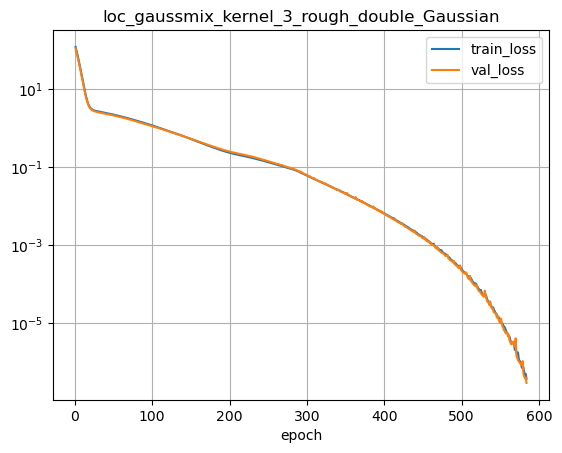

In [12]:
# R = 9
# run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime

n_components = 3
run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)
with torch.no_grad():
    amps   = model.kernel_conv.amplitudes.detach().cpu()
    sigmas = F.softplus(model.kernel_conv.log_sigmas).detach().cpu()
    print("amplitudes:", amps)
    print("sigmas    :", sigmas)


path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)




Model loc_window_kernel_1_rough_double_Gaussian: best val loss = 0.523642 at epoch 182
Best model: R=1, val_loss=0.523642
Model loc_window_kernel_2_rough_double_Gaussian: best val loss = 0.144076 at epoch 173
Best model: R=2, val_loss=0.144076
Model loc_window_kernel_3_rough_double_Gaussian: best val loss = 0.030452 at epoch 146
Best model: R=3, val_loss=0.030452
Model loc_window_kernel_4_rough_double_Gaussian: best val loss = 0.003333 at epoch 113
Best model: R=4, val_loss=0.003333
Model loc_window_kernel_5_rough_double_Gaussian: best val loss = 0.000389 at epoch 115
Best model: R=5, val_loss=0.000389
Model loc_window_kernel_6_rough_double_Gaussian: best val loss = 0.000026 at epoch 120
Best model: R=6, val_loss=0.000026
Model loc_window_kernel_7_rough_double_Gaussian: best val loss = 0.000008 at epoch 125
Best model: R=7, val_loss=0.000008
Model loc_window_kernel_8_rough_double_Gaussian: best val loss = 0.000007 at epoch 126
Best model: R=8, val_loss=0.000007
Model loc_window_kernel_

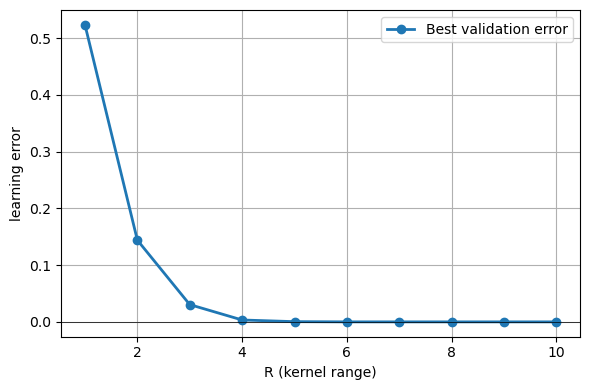

In [13]:
R_best = 0
best_val = math.inf

val_hist_R = []
learning_hist_R = []

for R in R_list:
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime

    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

    val_hist_R.append((R, val_loss))
    learning_hist_R.append((R, ))

    print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
    if val_loss < best_val:
        best_val = val_loss
        R_best = R

    print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

print("Validation history:")
for R, val_loss in val_hist_R:
    print(f"R={R}: val_loss={val_loss:.6f}")


plt.figure(figsize=(6,4))
plt.plot([x[0] for x in val_hist_R], [x[1] for x in val_hist_R], 'o-', label='Best validation error', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("R (kernel range)")
plt.ylabel("learning error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Model loc_gaussmix_kernel_1_rough_double_Gaussian: best val loss = 0.533274 at epoch 214
Best model: n_components=1, val_loss=0.533274
Model loc_gaussmix_kernel_2_rough_double_Gaussian: best val loss = 0.531253 at epoch 335
Best model: n_components=2, val_loss=0.531253
Model loc_gaussmix_kernel_3_rough_double_Gaussian: best val loss = 0.000007 at epoch 554
Best model: n_components=3, val_loss=0.000007
Model loc_gaussmix_kernel_4_rough_double_Gaussian: best val loss = 0.000002 at epoch 577
Best model: n_components=4, val_loss=0.000002
Model loc_gaussmix_kernel_5_rough_double_Gaussian: best val loss = 0.000004 at epoch 569
Best model: n_components=4, val_loss=0.000002
Model loc_gaussmix_kernel_6_rough_double_Gaussian: best val loss = 0.000005 at epoch 573
Best model: n_components=4, val_loss=0.000002
Model loc_gaussmix_kernel_7_rough_double_Gaussian: best val loss = 0.000007 at epoch 571
Best model: n_components=4, val_loss=0.000002
Validation history:
n_components=1: val_loss=0.533274
n

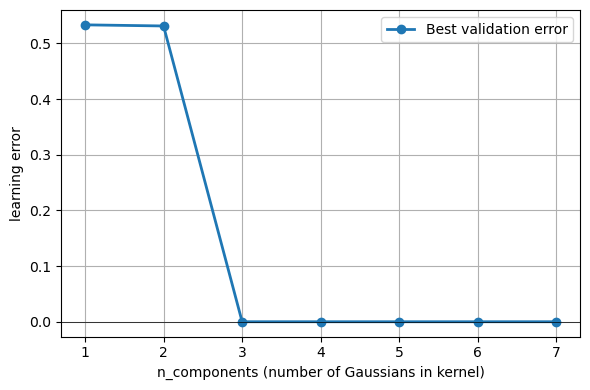

In [14]:
n_components_best = 0
best_val = math.inf

val_hist_n = []
learning_hist_n = []

for n in n_components_list:
    run_name = f"loc_gaussmix_kernel_{n}_" + data_regime + '_' + kernel_regime
    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)

    val_hist_n.append((n, val_loss))
    learning_hist_n.append((n, ))

    print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
    if val_loss < best_val:
        best_val = val_loss
        n_components_best = n

    print(f"Best model: n_components={n_components_best}, val_loss={best_val:.6f}")

print("Validation history:")
for n, val_loss in val_hist_n:
    print(f"n_components={n}: val_loss={val_loss:.6f}")


plt.figure(figsize=(6,4))
plt.plot([x[0] for x in val_hist_n], [x[1] for x in val_hist_n], 'o-', label='Best validation error', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("n_components (number of Gaussians in kernel)")
plt.ylabel("learning error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluate performance of training

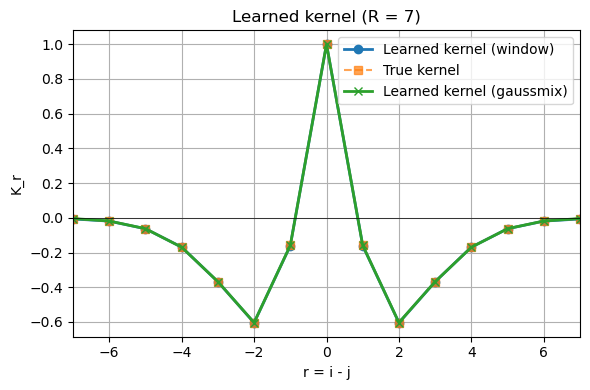

In [20]:

R = 7
run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime
model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

with torch.no_grad():
    k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 

r_grid = np.arange(-R, R+1)

if kernel_regime == "single_Gaussian":
    def K_true(r):
        return amp_Gaussian * np.exp(-(r**2) / (sigma_Gaussian**2))
elif kernel_regime == "double_Gaussian":
    def K_true(r):
        return (amp_Gaussian_1 * np.exp(-(r**2) / (sigma_Gaussian_1**2)) +
                amp_Gaussian_2 * np.exp(-(r**2) / (sigma_Gaussian_2**2)))
k_true = K_true(r_grid)

n_components = 4
run_name = f"loc_gaussmix_kernel_{n_components}_" + data_regime + '_' + kernel_regime
model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", GaussianMixtureEnergyNN, device=device)  
with torch.no_grad():
    r_grid_gm = model.kernel_conv.r_vals.cpu().numpy()       # shape (2R+1,)
    k_full_gm = model.kernel_conv.build_kernel().view(-1).cpu().numpy()




plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full , 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.plot(r_grid_gm, k_full_gm , 'x-', label='Learned kernel (gaussmix)', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Learned kernel (R = {R})")
plt.xlim(-R, R)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
targets_train_norm

plt.figure(figsize=(6,4))
plt.hist(targets_train_norm, bins=50)
plt.xlabel("targets_train_norm")
plt.ylabel("count")
plt.title("Histogram of targets_train_norm")
plt.tight_layout()
plt.show()

In [ ]:
def E_int_conv_discrete(rho: torch.Tensor,
                        k_full: torch.Tensor,
                        R: int) -> torch.Tensor:
    """
    Interaction energy with a finite-range kernel k_full of length 2R+1.
    rho: (N,) or (B, N)
    k_full: (2R+1,)  -- symmetric kernel [K_-R, ..., K_0, ..., K_R]
    R: kernel range
    Returns: (B,) energy
    """
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)  # (1, N)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    k_full = k_full.to(device=device, dtype=dtype)          # (2R+1,)
    weight = k_full.view(1, 1, -1)                          # (1, 1, 2R+1)

    # pad by R on each side for linear convolution with kernel of size 2R+1
    u = F.conv1d(rho.unsqueeze(1), weight, padding=R).squeeze(1)  # (B, N)

    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


rho_batch, d_rho_batch_analytical, _ = sample_density_batch(32)  # (B, N_grid)

if kernel_regime == "single_Gaussian":
    E_int_batch = amp_Gaussian * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian)
    E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
elif kernel_regime == "double_Gaussian":
    E_int_batch = (amp_Gaussian_1 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_1) +
                   amp_Gaussian_2 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_2))
    E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
print("E_int_batch:", E_int_batch)
print("E_int_batch_discrete:", E_int_batch_discrete)

